<a href="https://colab.research.google.com/github/Playmen998/Data-Analysis/blob/master/Employee_Access_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных, постановка задачи 

Ссылка на соревнование kaggle
https://www.kaggle.com/competitions/amazon-employee-access-challenge/overview 

Таблицы для скачивания https://drive.google.com/file/d/19M_M6PanVVjzXG3I5QDvxpWwU0fYNOHY/view?usp=sharing

In [1]:
! gdown --id 19M_M6PanVVjzXG3I5QDvxpWwU0fYNOHY

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19M_M6PanVVjzXG3I5QDvxpWwU0fYNOHY
To: /content/amazon-employee-access-challenge.zip
100% 1.61M/1.61M [00:00<00:00, 111MB/s]


In [2]:
! unzip /content/amazon-employee-access-challenge.zip -d /content/amazon_challenge

Archive:  /content/amazon-employee-access-challenge.zip
  inflating: /content/amazon_challenge/sampleSubmission.csv  
  inflating: /content/amazon_challenge/test.csv  
  inflating: /content/amazon_challenge/train.csv  


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("/content/amazon_challenge/train.csv")

In [5]:
test_main = pd.read_csv("/content/amazon_challenge/test.csv")

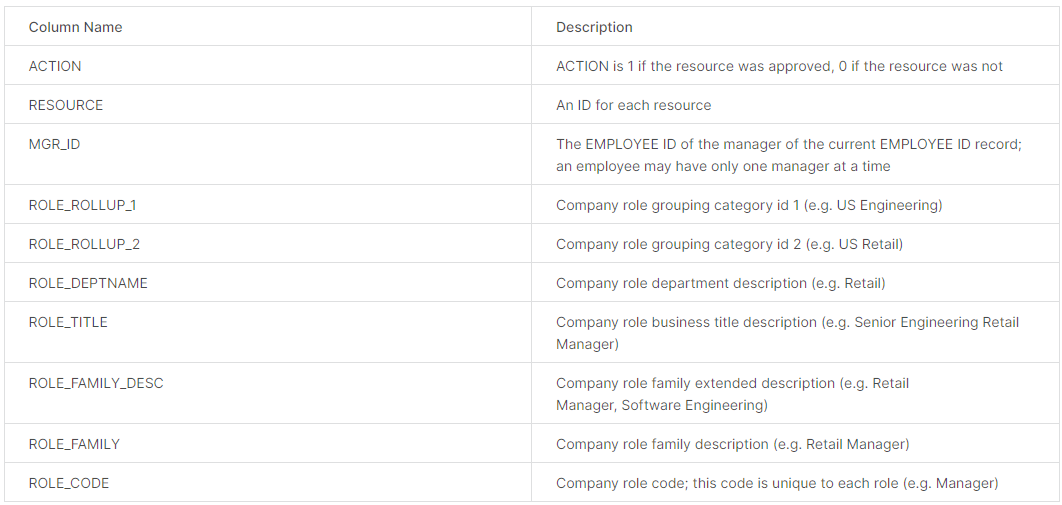

Given the data related to current employees and their provisioned access, models can be built that automatically determine access privileges as employees enter and leave roles within a company.
The objective of this competition is to build a model, learned using historical data, that will determine an employee's access needs, such that manual access transactions (grants and revokes) are minimized as the employee's attributes change over time. The model will take an employee's role information and a resource code and will return whether or not access should be granted.

В данном задании необходимо построить модель предсказание по выдачи доступов сотрудникам

# Первичный анализ данных

In [6]:
df

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325
...,...,...,...,...,...,...,...,...,...,...
32764,1,23497,16971,117961,118300,119993,118321,240983,290919,118322
32765,1,25139,311198,91261,118026,122392,121143,173805,249618,121145
32766,1,34924,28805,117961,118327,120299,124922,152038,118612,124924
32767,1,80574,55643,118256,118257,117945,280788,280788,292795,119082


In [7]:
df['ACTION'].value_counts(normalize=True)

1    0.94211
0    0.05789
Name: ACTION, dtype: float64

Видим, что у нас сильно несбалансированные классы. 1 гораздо больше, чем 0

In [8]:
df.isna().mean()

ACTION              0.0
RESOURCE            0.0
MGR_ID              0.0
ROLE_ROLLUP_1       0.0
ROLE_ROLLUP_2       0.0
ROLE_DEPTNAME       0.0
ROLE_TITLE          0.0
ROLE_FAMILY_DESC    0.0
ROLE_FAMILY         0.0
ROLE_CODE           0.0
dtype: float64

Пропущенных значений нет

# Посмотрим на зависимые переменные через корреляцию phik

In [9]:
! pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 7.6 MB/s 


In [10]:
import phik

In [11]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


In [12]:
phik_overview['ACTION'].sort_values(ascending=False)

ACTION              1.000000
ROLE_FAMILY         0.109428
ROLE_FAMILY_DESC    0.074811
MGR_ID              0.044255
ROLE_ROLLUP_2       0.043044
ROLE_DEPTNAME       0.031848
RESOURCE            0.030637
ROLE_ROLLUP_1       0.024685
ROLE_TITLE          0.020584
ROLE_CODE           0.000000
Name: ACTION, dtype: float64

Как мы видим больше всего влияет на предсказания значения ROLE_FAMILY, ROLE_FAMILY_DESC. ROLE_CODE phik показывает, что совсем не влияет

# Сделаем Baseline

In [13]:
train, test =train_test_split(df,train_size = 0.6, random_state=42,stratify=df['ACTION'])
val, test =train_test_split(test,train_size = 0.5, random_state=42,stratify=test['ACTION'])

In [14]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 87 kB/s 


In [15]:
from catboost import CatBoostClassifier

In [16]:
X = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE']

cat_features = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE']       

y = ['ACTION']

In [17]:
from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [18]:
params = {'verbose' : 100,
          'random_seed':42}

Установим базовые гиперпараметры, тестировать будем позже

In [19]:
model = CatBoostClassifier(**params)

In [20]:
model.fit(train_data, eval_set = valid_data)

Learning rate set to 0.066135
0:	learn: 0.6168757	test: 0.6168659	best: 0.6168659 (0)	total: 65.1ms	remaining: 1m 5s
100:	learn: 0.1598228	test: 0.1456104	best: 0.1456088 (98)	total: 8.73s	remaining: 1m 17s
200:	learn: 0.1507532	test: 0.1432494	best: 0.1432186 (199)	total: 18.7s	remaining: 1m 14s
300:	learn: 0.1431835	test: 0.1428621	best: 0.1426427 (265)	total: 23.8s	remaining: 55.2s
400:	learn: 0.1360058	test: 0.1427127	best: 0.1425106 (393)	total: 29s	remaining: 43.3s
500:	learn: 0.1297795	test: 0.1433640	best: 0.1425106 (393)	total: 34.2s	remaining: 34.1s
600:	learn: 0.1236364	test: 0.1434023	best: 0.1425106 (393)	total: 39.4s	remaining: 26.2s
700:	learn: 0.1185013	test: 0.1437230	best: 0.1425106 (393)	total: 44.5s	remaining: 19s
800:	learn: 0.1139154	test: 0.1439965	best: 0.1425106 (393)	total: 49.7s	remaining: 12.3s
900:	learn: 0.1091970	test: 0.1441639	best: 0.1425106 (393)	total: 54.9s	remaining: 6.03s
999:	learn: 0.1046520	test: 0.1444030	best: 0.1425106 (393)	total: 1m	remain

In [21]:
test['score_baseline'] = model.predict_proba(test[X])[:,1]

Посчитаем функцию log_loss, uplift для тестовой выборки

In [22]:
from sklearn.metrics import log_loss

In [23]:
log_loss(test['ACTION'],test["score_baseline"])

0.14437257167593398

log_loss функция показывает 14.4% это значит, что в таком кол-во процентов мы ошиблись в предсказании 1

In [25]:
from sklearn.metrics import roc_auc_score

In [27]:
roc_auc_score(test['ACTION'],test["score_baseline"])

0.8827466199512386

Метрика roc_auc показывает площадь под ROC-кривой. ROC-кривая – это кривая вероятности, которая отображает отношение TPR к FPR при различных пороговых значениях. Площадь под кривой (AUC) является мерой способности классификатора различать классы. Чем выше площадь под кривой, тем лучше производительность модели. В нашем случае плгощадь под кривой равна 0.882

# Подбор гиперпараметров

##Метод get_feature_importance

Посмотрим на фичи, которые больше всего влияют на модель (возьмем тип importance - LossFunctionChange, который смотрит на изменение loss_function функции). Значения, которые мы получили внизу, показывают насколько изменились функция по которой оптимизируемся (оптимизируемся по log_loss), если поменяем значения признака

In [28]:
model.get_feature_importance(valid_data,
                             'LossFunctionChange',
                             prettified=True)

,Feature Id,Importances
0,MGR_ID,0.005497
1,RESOURCE,0.005134
2,ROLE_TITLE,0.004687
3,ROLE_FAMILY_DESC,0.001322
4,ROLE_DEPTNAME,0.000900
5,ROLE_ROLLUP_2,0.000391
6,ROLE_CODE,-0.000148
7,ROLE_FAMILY,-0.000305
8,ROLE_ROLLUP_1,-0.000595


Видим, что в Baseline оказались не нужными фичи ROLE_CODE, ROLE_FAMILY,  ROLE_ROLLUP_1 попробуем исключить их

In [29]:
X = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC']

cat_features = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC']       

y = ['ACTION']

In [30]:
from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [31]:
params = {'verbose' : 100,
          'random_seed':42}

In [32]:
model = CatBoostClassifier(**params)

In [33]:
model.fit(train_data, eval_set = valid_data)

Learning rate set to 0.066135
0:	learn: 0.6136187	test: 0.6130121	best: 0.6130121 (0)	total: 31.4ms	remaining: 31.4s
100:	learn: 0.1590077	test: 0.1430675	best: 0.1430675 (100)	total: 2.46s	remaining: 21.9s
200:	learn: 0.1488856	test: 0.1405062	best: 0.1404850 (196)	total: 4.94s	remaining: 19.6s
300:	learn: 0.1418588	test: 0.1406567	best: 0.1403071 (208)	total: 8.42s	remaining: 19.6s
400:	learn: 0.1358745	test: 0.1408587	best: 0.1403071 (208)	total: 12.7s	remaining: 18.9s
500:	learn: 0.1290180	test: 0.1416510	best: 0.1403071 (208)	total: 17.2s	remaining: 17.1s
600:	learn: 0.1234689	test: 0.1417518	best: 0.1403071 (208)	total: 19.7s	remaining: 13.1s
700:	learn: 0.1178733	test: 0.1422266	best: 0.1403071 (208)	total: 22.2s	remaining: 9.47s
800:	learn: 0.1126234	test: 0.1420279	best: 0.1403071 (208)	total: 24.7s	remaining: 6.13s
900:	learn: 0.1074447	test: 0.1426254	best: 0.1403071 (208)	total: 27.2s	remaining: 2.98s
999:	learn: 0.1030372	test: 0.1428078	best: 0.1403071 (208)	total: 29.6s	

In [34]:
test['score_baseline_nofeatures'] = model.predict_proba(test[X])[:,1]

Функция log loss на baseline

In [ ]:
log_loss(test['ACTION'],test["score_baseline"])

0.14437257167593398

Функция log loss на модели без 3 фичей

In [35]:
log_loss(test['ACTION'],test["score_baseline_nofeatures"])

0.14370203975128218

**Как видим на функцию log_loss, это позитивно повлияло**

Функция roc-auc на baseline

In [ ]:
roc_auc_score(test['ACTION'],test["score_baseline"])

0.8827466199512386

Функция roc-auc на модели без 3 фичей

In [36]:
roc_auc_score(test['ACTION'],test["score_baseline_nofeatures"])

0.8838701771435391

**На показатель roc_auc это также позитивно повлияло**

##Меняем гиперпараметры: eval_metric, loss_function, early_stopping_rounds

Укажем eval_metric = AUC и loss_function = LogLoss, а также укажем параметр early_stopping_rounds = 100, означающий, что если после 100 итерации метрика не улучшится, то мы останавливаем модель

In [37]:
params = {'verbose' : 100,
          'random_seed':42,
          "eval_metric" : "AUC",
          "loss_function" : "Logloss",
          'early_stopping_rounds': 100
          }

In [38]:
model = CatBoostClassifier(**params)

In [39]:
model.fit(train_data, eval_set = valid_data)

Learning rate set to 0.066135
0:	test: 0.5954850	best: 0.5954850 (0)	total: 27.4ms	remaining: 27.4s
100:	test: 0.8822238	best: 0.8823396 (99)	total: 2.51s	remaining: 22.4s
200:	test: 0.8854296	best: 0.8854296 (200)	total: 5.01s	remaining: 19.9s
300:	test: 0.8858176	best: 0.8858291 (298)	total: 7.47s	remaining: 17.3s
400:	test: 0.8880049	best: 0.8882583 (353)	total: 9.97s	remaining: 14.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8882582547
bestIteration = 353

Shrink model to first 354 iterations.


In [40]:
test['score_baseline_nofeatures_test1'] = model.predict_proba(test[X])[:,1]

In [41]:
log_loss(test['ACTION'],test["score_baseline_nofeatures_test1"])

0.14331898646746477

In [42]:
roc_auc_score(test['ACTION'],test["score_baseline_nofeatures_test1"])

0.8870558624452288

log_loss функция снова показывает лучше результат, также как и метрика roc-auc

##Тестируем eval_metric - Prauc

Метрика Prauc обозначает Mean Average Precision или по другому Precision Recall Curve. Данная метрика как и roc auc показывает площадь под кривой, однако она является более устойчивым показателям, когда мы имеем дело с не сбалансированными классами, поэтому протестируем данную метрику

In [43]:
params = {'verbose' : 100,
          'random_seed':42,
          'eval_metric':'PRAUC',
          "loss_function" : "Logloss",
          'early_stopping_rounds': 100
          }

In [44]:
model = CatBoostClassifier(**params)

In [45]:
model.fit(train_data, eval_set = valid_data)

Learning rate set to 0.066135
0:	learn: 0.9611684	test: 0.9630753	best: 0.9630753 (0)	total: 27.6ms	remaining: 27.6s
100:	learn: 0.9858350	test: 0.9887182	best: 0.9887575 (99)	total: 3.42s	remaining: 30.5s
200:	learn: 0.9880684	test: 0.9891499	best: 0.9891982 (154)	total: 6.13s	remaining: 24.4s
300:	learn: 0.9893647	test: 0.9893802	best: 0.9894410 (296)	total: 9.64s	remaining: 22.4s
400:	learn: 0.9905376	test: 0.9898785	best: 0.9898985 (395)	total: 13.2s	remaining: 19.7s
500:	learn: 0.9918794	test: 0.9895672	best: 0.9899267 (407)	total: 15.9s	remaining: 15.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9899267115
bestIteration = 407

Shrink model to first 408 iterations.


In [46]:
test['score_baseline_nofeatures_test2'] = model.predict_proba(test[X])[:,1]

In [47]:
log_loss(test['ACTION'],test["score_baseline_nofeatures_test2"])

0.1435695842299105

In [48]:
roc_auc_score(test['ACTION'],test["score_baseline_nofeatures_test2"])

0.8872775049869572

Видим, что функция log_loss показала немного худший результат, однако метрика roc auc для нас более ценна, поэтому будем орентироваться на нее

##Найдем learning_rate, depth, n_estimators через grid_search

In [61]:
params = {'verbose' : 100,
          'random_seed':42,
          "eval_metric" : "PRAUC",
          "loss_function" : "Logloss",
          'early_stopping_rounds': 200
          }

In [62]:
model = CatBoostClassifier(**params)

In [63]:
grid = {'learning_rate':[0.035, 0.05,0.06,0.065,0.07,0.075, 0.09, 0.1],
        'depth':[5,6,7],
        'n_estimators':[300,500,700,1000]}

In [64]:
result = model.grid_search(grid, train_data, verbose=False)

0:	learn: 0.9711979	test: 0.9705060	best: 0.9705060 (0)	total: 11.2ms	remaining: 3.35s
100:	learn: 0.9813217	test: 0.9840599	best: 0.9840599 (100)	total: 2.32s	remaining: 4.57s
200:	learn: 0.9839571	test: 0.9850676	best: 0.9850676 (200)	total: 4.66s	remaining: 2.29s
299:	learn: 0.9849031	test: 0.9852277	best: 0.9852747 (294)	total: 6.93s	remaining: 0us

bestTest = 0.9852746732
bestIteration = 294

0:	learn: 0.9711979	test: 0.9705060	best: 0.9705060 (0)	total: 11.7ms	remaining: 3.5s
100:	learn: 0.9834550	test: 0.9840012	best: 0.9840161 (99)	total: 2.33s	remaining: 4.59s
200:	learn: 0.9849358	test: 0.9852633	best: 0.9852705 (199)	total: 4.63s	remaining: 2.28s
299:	learn: 0.9858410	test: 0.9852451	best: 0.9854164 (275)	total: 7.65s	remaining: 0us

bestTest = 0.9854164488
bestIteration = 275

0:	learn: 0.9711979	test: 0.9705060	best: 0.9705060 (0)	total: 10.8ms	remaining: 3.24s
100:	learn: 0.9837574	test: 0.9851168	best: 0.9851168 (100)	total: 2.28s	remaining: 4.49s
200:	learn: 0.9854853	t

In [65]:
result['params']

{'depth': 6, 'iterations': 300, 'learning_rate': 0.1}

In [66]:
params = {'verbose' : 100,
          'random_seed':42,
          "eval_metric" : "PRAUC",
          "loss_function" : "Logloss",
          'early_stopping_rounds': 200,
          'depth': 6, 
          'iterations': 300, 
          'learning_rate': 0.1
          }

In [67]:
model = CatBoostClassifier(**params)

In [68]:
model.fit(train_data, eval_set = valid_data)

0:	learn: 0.9611684	test: 0.9630753	best: 0.9630753 (0)	total: 27.1ms	remaining: 8.1s
100:	learn: 0.9869822	test: 0.9881105	best: 0.9881233 (99)	total: 2.83s	remaining: 5.59s
200:	learn: 0.9894728	test: 0.9886706	best: 0.9886738 (167)	total: 5.56s	remaining: 2.74s
299:	learn: 0.9912927	test: 0.9892804	best: 0.9892804 (299)	total: 8.23s	remaining: 0us

bestTest = 0.9892803581
bestIteration = 299



In [69]:
test['score_baseline_nofeatures_test3'] = model.predict_proba(test[X])[:,1]

In [70]:
log_loss(test['ACTION'],test["score_baseline_nofeatures_test3"])

0.14445797513194733

In [71]:
roc_auc_score(test['ACTION'],test["score_baseline_nofeatures_test3"])

0.8832568240328712

Как видим параметры roc auc и log loss ухудшились по сравнению с последней модели, значит не будем изменять параметры: learning_rate, depth, n_estimators

# Обучимся на train + val

In [107]:
train_full = pd.concat([train, val])

In [108]:
params = {'verbose' : 100,
          'random_seed':42,
          "eval_metric" : "PRAUC",
          "loss_function" : "Logloss",
          'early_stopping_rounds': 200
         }

In [ ]:
model = CatBoostClassifier(**params)

In [109]:
train_full_data = Pool(train_full[X],
                       label = train_full[y],
                       cat_features=cat_features)

In [110]:
model.fit(train_full_data, eval_set = valid_data)

Learning rate set to 0.071005
0:	learn: 0.9716822	test: 0.9735680	best: 0.9735680 (0)	total: 34.6ms	remaining: 34.6s
100:	learn: 0.9869800	test: 0.9995685	best: 0.9995685 (100)	total: 3.49s	remaining: 31.1s
200:	learn: 0.9883752	test: 0.9996874	best: 0.9996952 (187)	total: 6.92s	remaining: 27.5s
300:	learn: 0.9892252	test: 0.9997217	best: 0.9997218 (297)	total: 11.2s	remaining: 26s
400:	learn: 0.9903570	test: 0.9997342	best: 0.9997368 (393)	total: 14.8s	remaining: 22.1s
500:	learn: 0.9914343	test: 0.9997413	best: 0.9997540 (468)	total: 18.2s	remaining: 18.1s
600:	learn: 0.9923577	test: 0.9997414	best: 0.9997540 (468)	total: 21.6s	remaining: 14.3s
700:	learn: 0.9933140	test: 0.9997517	best: 0.9997657 (658)	total: 25.1s	remaining: 10.7s
800:	learn: 0.9940189	test: 0.9997418	best: 0.9997657 (658)	total: 30.1s	remaining: 7.47s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9997656523
bestIteration = 658

Shrink model to first 659 iterations.


In [111]:
test['score_train_full'] = model.predict_proba(test[X])[:,1]

In [112]:
log_loss(test['ACTION'],test["score_train_full"])

0.1385601283836758

In [113]:
roc_auc_score(test['ACTION'],test["score_train_full"])

0.8968300854176258

Значения метрик улучшились

# Найдем лучший порог

Искать оптимальный порог мы будем по метрике Average Precision Score (тк эта метрика подходит из-за дисбаланса классов) порог будем искать на тестовой выборке т.к. модель эти данные видит первый раз, а значит мы исключаем вероятность того, что модель запомнила эти данные

In [125]:
from sklearn.metrics import average_precision_score

In [115]:
thrs =[0] + list(test['score_train_full'].unique())

In [116]:
from tqdm.notebook import tqdm

In [126]:
result = []
for thr in tqdm(thrs):
  test['y_pred_new'] = (test['score_train_full'] > thr) * 1
  result.append((thr,
                 average_precision_score(test['ACTION'],test['y_pred_new'])))

  0%|          | 0/6369 [00:00<?, ?it/s]

In [127]:
t = pd.DataFrame(result, columns =['thr','avg_prec'])

In [130]:
t.sort_values('avg_prec',ascending=False).head(5)

,thr,avg_prec
154,0.952403,0.980327
3197,0.952414,0.980318
5411,0.952447,0.980309
1426,0.952477,0.980299
265,0.952546,0.980290


Видим, что самая большое значение avg_prec имеется при процентном значении 0.952403. Будем использовать его

#Обучимся на всех данных

In [143]:
train, val = train_test_split(df,train_size = 0.6, random_state=42,stratify=df['ACTION'])

In [144]:
train_full_data = pd.concat([train, val])

In [145]:
X = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC']

cat_features = ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC']       

y = ['ACTION']

In [146]:
from catboost import Pool

train_data = Pool(data=train_full_data[X],
                  label=train_full_data[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [147]:
params = {'verbose' : 100,
          'random_seed':42,
          'eval_metric':'PRAUC',
          "loss_function" : "Logloss",
          'early_stopping_rounds': 200
          }

In [ ]:
model = CatBoostClassifier(**params)

In [148]:
model.fit(train_data, eval_set = valid_data)

Learning rate set to 0.075029
0:	learn: 0.9718964	test: 0.9722346	best: 0.9722346 (0)	total: 40.2ms	remaining: 40.2s
100:	learn: 0.9882480	test: 0.9995365	best: 0.9995373 (99)	total: 4.28s	remaining: 38.1s
200:	learn: 0.9894906	test: 0.9997396	best: 0.9997396 (200)	total: 9.6s	remaining: 38.1s
300:	learn: 0.9904265	test: 0.9998067	best: 0.9998072 (294)	total: 14s	remaining: 32.5s
400:	learn: 0.9913995	test: 0.9998350	best: 0.9998368 (394)	total: 18.2s	remaining: 27.2s
500:	learn: 0.9922531	test: 0.9998571	best: 0.9998571 (500)	total: 22.4s	remaining: 22.3s
600:	learn: 0.9928687	test: 0.9998448	best: 0.9998600 (511)	total: 26.5s	remaining: 17.6s
700:	learn: 0.9934403	test: 0.9998505	best: 0.9998600 (511)	total: 30.7s	remaining: 13.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.999860017
bestIteration = 511

Shrink model to first 512 iterations.


#Проведем кроссвалидацию

In [149]:
from catboost import cv

In [150]:
params = {'verbose' : 100,
          'random_seed':42,
          'eval_metric':'PRAUC',
          "loss_function" : "Logloss",
          'early_stopping_rounds': 200
          }

In [151]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count = 7,
    shuffle = True,
    partition_random_seed = 0,
    verbose=False,
    stratified=True
)

Training on fold [0/7]

bestTest = 0.9908471138
bestIteration = 165

Training on fold [1/7]

bestTest = 0.991379179
bestIteration = 877

Training on fold [2/7]

bestTest = 0.9913390041
bestIteration = 999

Training on fold [3/7]

bestTest = 0.9909359083
bestIteration = 945

Training on fold [4/7]

bestTest = 0.9930234016
bestIteration = 925

Training on fold [5/7]

bestTest = 0.9871033291
bestIteration = 999

Training on fold [6/7]

bestTest = 0.9921421734
bestIteration = 999



Найдем самую лучшую итерацию по максимальному значению test-PRAUC-mean 

In [168]:
n_iters = cv_data[cv_data['test-PRAUC-mean'] == cv_data['test-PRAUC-mean'].max()].values[0]

#Обучим модель и сделаем предсказание на test_main

In [164]:
params = {'verbose' : 100,
          'random_seed':42,
          'eval_metric':'PRAUC',
          "loss_function" : "Logloss",
          'early_stopping_rounds': 200,
          'iterations':n_iters
          }

In [165]:
model = CatBoostClassifier(**params)

In [166]:
model.fit(train_data, eval_set = valid_data)

Learning rate set to 0.075029
0:	learn: 0.9718559	test: 0.9719006	best: 0.9719006 (0)	total: 34.9ms	remaining: 34.9s
100:	learn: 0.9880171	test: 0.9994724	best: 0.9994724 (100)	total: 6.16s	remaining: 54.8s
200:	learn: 0.9889850	test: 0.9996311	best: 0.9996337 (198)	total: 13.1s	remaining: 52s
300:	learn: 0.9898386	test: 0.9996607	best: 0.9996607 (300)	total: 17.3s	remaining: 40.1s
400:	learn: 0.9908462	test: 0.9997228	best: 0.9997294 (371)	total: 21.5s	remaining: 32.1s
500:	learn: 0.9915767	test: 0.9997399	best: 0.9997399 (500)	total: 25.6s	remaining: 25.5s
600:	learn: 0.9923246	test: 0.9997542	best: 0.9997542 (600)	total: 29.8s	remaining: 19.8s
700:	learn: 0.9930177	test: 0.9997559	best: 0.9997610 (634)	total: 34.1s	remaining: 14.5s
800:	learn: 0.9935732	test: 0.9997615	best: 0.9997682 (744)	total: 38.3s	remaining: 9.51s
900:	learn: 0.9940984	test: 0.9997644	best: 0.9997723 (829)	total: 42.5s	remaining: 4.67s
999:	learn: 0.9945847	test: 0.9997758	best: 0.9997758 (999)	total: 46.6s	re

In [169]:
test_main['prod'] = model.predict_proba(test_main[X])[:,1]

Подставим полученный порог и сделаем предсказание в столбце ACTION

In [170]:
test_main['ACTION'] = (test_main['prod'] > 0.952403) * 1

In [171]:
test_main.drop(columns = ['prod'],axis = 1, inplace=True)

Скачиваем таблицу

In [172]:
test_main[['id','ACTION']].to_csv('amazon.csv', index = False)

SUBMISSION по этой модели:

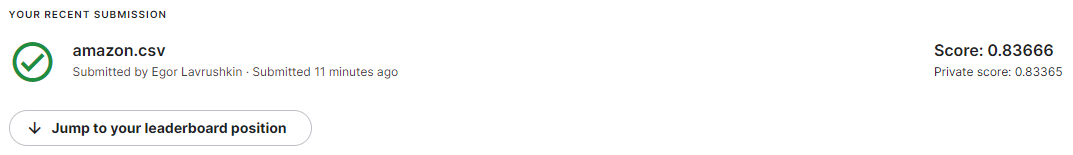